## Importing Standard Modules ...
Here we have imported sklearn datasets which are optimized and preprocessed ***20newsgroups*** this set we will be loading and we will be using. The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups. To the best of my knowledge, it was originally collected by Ken Lang, probably for his Newsweeder: Learning to filter netnews paper, though he does not explicitly mention this collection.The data is organized into 20 different newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related to each other (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are highly unrelated (e.g misc.forsale / soc.religion.christian). 



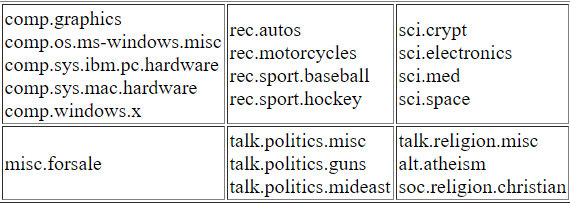

In [1]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')
from pprint import pprint
pprint(list(newsgroups_train.target_names))
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import numpy as np
from sklearn.metrics import accuracy_score

PermissionError: [WinError 5] Access is denied: 'C:\\Users\\admin'

## MultinomialNB
We will do the following steps :


1.   Choose only few categories or files so that system doesn't crash
2.   We will vectorize the data to generate a sparse array (**TfidfVectorizer** is a sklearn predefines vectorizer)
3.   The vectorized data of train will be fed for training the model
4.   We will predict test data set with this model
5.   We will calculate F1 score and accuracies.



In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
categories = ['alt.atheism', 'talk.religion.misc','comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',categories=categories)
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(newsgroups_train.data)
vectors.shape
newsgroups_test = fetch_20newsgroups(subset='test',categories=categories)
vectors_test = vectorizer.transform(newsgroups_test.data)
clf = MultinomialNB(alpha=.01)
clf.fit(vectors, newsgroups_train.target)
vectors_test = vectorizer.transform(newsgroups_test.data)
pred = clf.predict(vectors_test)

In [3]:
print("F1_Score ",metrics.f1_score(newsgroups_test.target, pred, average='macro'))
print("Accuracy",accuracy_score(newsgroups_test.target,pred))

F1_Score  0.8821359240272957
Accuracy 0.893569844789357


## Implementation...
Here I have implemented MultinomialNB which will do same work. 


This algorithm I have implemented from the <a href= 'https://nlp.stanford.edu/IR-book/pdf/13bayes.pdf'>Cambridge Book</a>. A sligth modification to the corresponding one is that taking natural logarithm of the probabilities so that clalucaltion will be slight easier. 


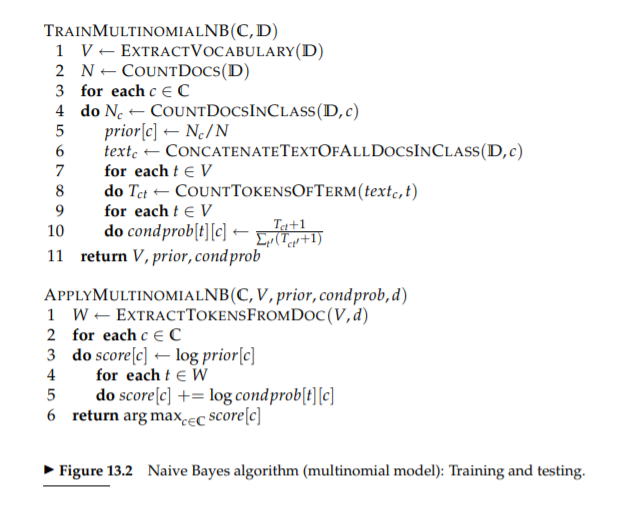

First we will calculate the number of classes using the np.unique operation then we will calucalte class prior probabilities and take natural logarithmic of it so that we will be extending range from 0 to 1 over wide range of values this makes calculation easier in argmax and all. Then we will calculate for each word which will be treated as a feature here and we will calculate it's occurences in each class label column and divide it by the total occurences which is nothing but the sum of all values in that feature column so that we ge probability of that feature in that column and this is **likelihood probability** and the class probability is called as **class prior probability**.

We know that

**posterior probability = (likelihood probability * class prior probability)/evidence**

We also know that evidence is same for all the columns as it is the probability of picking a column from a set in this current example

As we have used natural logarithmic over probabilities so we have to add instead of multiplication this saves lot of time inmmatrix multiplication in case of large calculations. In prediction as we know likelihood of everyword in each class we can simply multiply that value with word occurrence in a given text provided as test then we need to add the class probailities to it. This goes down in a simple operation!.

Now we will be returned with an matrix having rows equal to the number of classes to each feature we need to pick the index in each column having high probability and return as a 1D array having length equal to the number of columns.

In [4]:
class MultinomialNB_own(object):
  def __init__(self,alpha):
    self.alpha = alpha # alpha is just used for smoothening here
  def fit(self,X,y):
    seperated = [[x for x, t in zip(X, y) if t == c] for c in np.unique(y)] # Extracting the rows of each class as a matrix here
    count_sample = (X.shape)[0] # Getting total rows present
    self.class_log_prior_ = [np.log(len(i) / count_sample) for i in seperated] # Calculating the class prior probavilties and applying natural log over it
    count = np.array([np.array(i).sum(axis=0) for i in seperated]) + self.alpha # Counting occurence of each word in each class
    self.feature_log_prob_ = np.log(count / count.sum(axis=1)[np.newaxis].T) # Calculating likelihood probabilities
  def predict_log_proba(self, X):
    return [(self.feature_log_prob_ * x).sum(axis=1) + self.class_log_prior_ for x in X] # Simply caluclating posterior probabilities for each class of the word and returning the array of the values seperated for each class
  def predict(self, X):
    return np.argmax(self.predict_log_proba(X), axis=1) # Simply picking the column which has highest value for each word of the given array as test set

In [5]:
print(vectors.shape)
print(newsgroups_train.target.shape)

(2034, 34118)
(2034,)


In [6]:
vectors.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Trying Out ...
Here we are just trying out how well does our algorithm work for the given dataset...

In [7]:
classifer = MultinomialNB_own(0.01)
classifer.fit(vectors.toarray(),newsgroups_train.target)

In [9]:
y_predict = classifer.predict(vectors_test.toarray())
print("F1_Score ",metrics.f1_score(newsgroups_test.target, y_predict, average='macro'))
print("Accuracy",accuracy_score(newsgroups_test.target,y_predict))

F1_Score  0.8821359240272957
Accuracy 0.893569844789357


## Logistic Regression ...
Here we are using Sklearn's logistic regression to predict the values and we will find F1 score even ...

In [10]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(vectors, newsgroups_train.target)

In [11]:
y_predict = clf.predict(vectors_test)
y_predict

array([2, 1, 1, ..., 3, 1, 1])

In [12]:
print("F1_Score ",metrics.f1_score(newsgroups_test.target, y_predict, average='macro'))
print("Accuracy",accuracy_score(newsgroups_test.target,y_predict))

F1_Score  0.8575634662448817
Accuracy 0.8721359940872137


## Logistic Regression ...
Here I have implemented Logistic Regression using gradient descent knowledge.


Here we use the basic scratch knowledge that by replacing linear regression with sigmoid function we are able to achieve the **logistic regression**. This will have learning rate and iterations by which our algorithm adjusts weights to reach the **local optimum or global optimum in some cases as the algorithm converges**. 

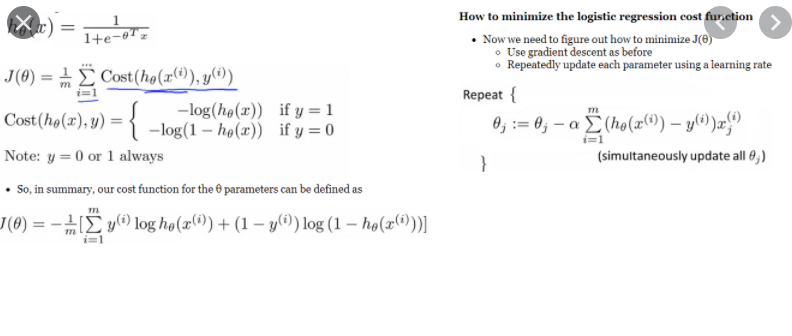


This is is the algorithm taken from Machine Learning series of the AndrewNg. The same algorithm is implemented here.

In [3]:
class LogisticRegressionGradient():
    def __init__ (self,learning = 0.001,iterations = 5000):
        self.learning = learning
        self.iterations = iterations
    def initialize_weights(self,X):
        #print("Initializing Weights",(X.shape)[1])
        self.weights = np.zeros((X.shape)[1]) # Weights will be initialized
    def sigmoid(self,z):
        #print("Entered Sigmoid Function")
        return (1/(1+np.exp(-z))) # Sigmoid value computation
    def logLoss(self,X,y):
        #print("LogLoss function is entered!")
        return ((-1/len(y))*(y*np.log(self.sigmoid(np.dot(X,self.weights)))+(1-y)*np.log(1-self.sigmoid(np.dot(X,self.weights)))).sum())
    def gradientDescent(self,X,y):
        return (np.dot(X.T,(y-self.sigmoid(np.dot(X,self.weights))))) # Gradient Descent
    def fit(self,X,y):
        self.initialize_weights(X)
        for i in range(0,self.iterations):
            self.weights = self.weights + self.learning * self.gradientDescent(X,y) # Computing weights by gradient Descent
        print("LogLoss final ",self.logLoss(X,y))# Calculating LogLoss after the iterations that we have came over
        print("Finally the weights",self.weights)
    def predict(self,X):
        y_predict = []
        for i in X:
            y_predict.append(self.sigmoid(np.dot(self.weights,i))) # Weights multiplied by X vector gives values of y
        return y_predict
    

In [5]:
# Appending 1's as the first column in these matrices as our algorithm requires Theta0
import numpy as np
X_train = np.array([[0.28,0.98,0.94,0.15],[0.33,0.57,0.58,0.04],[0.23,0.96,0.77,0.97]])
X = np.hstack((np.ones((X_train.shape[0], 1)), X_train))

In [6]:
y = np.array([1,2,3])

In [7]:
X.shape

(3, 5)

In [8]:
np.unique(y)

array([1, 2, 3])

In [9]:
import pandas as pd

In [10]:
# Converting into dataframes to use one hot encoding as we apply One Vs All
df_y = pd.DataFrame(data=y,columns=['Y'])


In [11]:
df_y

,Y
0,1
1,2
2,3


In [15]:
df_y = pd.get_dummies(data=df_y,columns=['Y'])

In [20]:
# As logistic regression returns probability between two classes
# So we are using One Vs All and then extracting the class to which a value belongs by using argmax
res = []
for i in df_y.columns:
  y = (np.array(df_y[i]))
  clf = LogisticRegressionGradient(0.01,200)
  clf.fit(X,y)
  print(clf.predict(t))

LogLoss final  0.5969489159422744
Finally the weights [-0.37513133 -0.11189027 -0.00658612  0.07245956 -0.5445389 ]
[array([1.16675201e-03, 1.17738243e-01, 4.70397113e-01, 7.86553094e-01,
       5.53543374e-05]), array([3.58655547e-03, 1.57313538e-01, 4.75322110e-01, 7.47796282e-01,
       2.83480560e-04]), array([0.0229479 , 0.24621487, 0.48354064, 0.6736182 , 0.00429761]), array([2.46744558e-03, 1.43042767e-01, 4.73679863e-01, 7.61215129e-01,
       1.64469261e-04])]
LogLoss final  0.5158933926367264
Finally the weights [-0.02334074  0.082844   -0.509653   -0.36209994 -0.60653992]
[array([3.96484843e-01, 8.16257117e-01, 1.03715638e-04, 1.47473820e-03,
       1.81337314e-05]), array([4.13355476e-01, 7.76026686e-01, 4.78299547e-04, 4.35745929e-03,
       1.11865790e-04]), array([0.44191162, 0.69602497, 0.00608074, 0.0260587 , 0.00231645]), array([4.07707195e-01, 7.90095971e-01, 2.87371329e-04, 3.03774003e-03,
       6.09961532e-05])]
LogLoss final  0.48483992095688505
Finally the weigh

In [24]:
t = np.array([[1,18,15,10,16]])

In [25]:
clf.logLoss(t,np.array([1]))

0.009933651860932086

In [23]:
res = np.array(res)

In [24]:
# Application argmax to get max value in each row of corresponding column to know which class it belongs
prediction = []
for i in range(0,len(res[0])):
  temp = np.array(res[:,i])
  print(np.argmax(temp))
  prediction.append(np.argmax(temp))


2
1
1
1
1
1
2
2
0
2
1
1
1
2
1
0
0
1
1
2
2
2
0
0
3
2
3
1
1
3
0
1
0
1
3
0
1
2
3
1
0
3
3
2
3
1
0
3
1
1
3
1
0
0
2
2
1
2
1
2
0
0
0
2
2
1
3
3
2
1
0
0
2
1
2
2
3
3
0
1
1
2
1
1
0
2
3
0
2
3
0
0
2
0
2
3
1
3
1
2
3
0
1
0
3
0
0
0
2
0
3
0
2
1
2
2
2
1
2
0
1
0
0
0
3
1
2
1
2
2
2
2
0
2
3
2
2
3
1
1
3
3
1
3
3
3
1
1
1
2
2
2
3
1
0
3
2
0
0
0
2
0
2
1
2
1
1
1
2
2
2
0
0
3
1
1
0
0
3
2
1
3
3
1
2
1
1
2
1
0
0
3
1
1
3
1
3
3
3
2
2
3
2
3
2
2
1
3
2
1
1
2
2
1
2
1
1
1
2
0
3
1
1
0
2
0
0
0
2
2
1
2
1
1
0
1
1
1
2
1
1
2
2
1
1
3
0
3
2
3
3
3
2
0
1
1
2
1
0
1
1
0
0
2
2
2
0
3
2
1
0
0
2
2
0
3
1
3
2
3
3
2
2
3
3
0
3
3
1
2
1
2
2
3
0
0
0
1
2
1
1
0
0
0
2
0
2
0
0
1
2
3
0
1
2
0
1
2
0
2
1
2
1
1
2
2
1
0
0
1
0
1
2
2
2
2
2
0
0
2
2
0
1
2
3
1
3
2
3
1
3
1
0
2
0
3
2
3
2
2
1
2
3
1
3
1
1
3
0
2
2
2
1
0
1
1
1
0
1
1
3
1
1
1
0
1
1
3
0
2
1
0
0
2
2
2
0
1
3
2
2
2
0
0
2
2
2
1
1
1
2
2
0
2
2
3
1
0
1
0
2
3
2
2
1
0
1
1
2
1
1
3
1
0
3
1
1
1
1
2
2
1
0
2
3
0
2
3
1
1
0
2
1
0
1
3
1
3
0
1
3
2
2
0
0
3
1
0
1
1
0
0
1
0
1
1
0
0
3
1
1
1
2
0
0
2
2
2
0
2
3
2
0
0
1
3
2
2
2
0


In [25]:
print("F1_Score")
metrics.f1_score(newsgroups_test.target, prediction, average='macro')

F1_Score


0.8634489688194152

In [26]:
print("Accuracy")
accuracy_score(newsgroups_test.target,prediction)

Accuracy


0.8787878787878788